In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline

from graphviz  import Source
from IPython.display import SVG, display, HTML
style = "<style>svg{width: 50% !important; height: 50% !important;} </style>" 
HTML( style )

In [2]:
titanic_data = pd.read_csv('train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
X = titanic_data.drop(['PassengerId','Name','Ticket','Cabin','Survived'], axis=1)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [5]:
#one hot encoding
X = pd.get_dummies(X)
#заполняем Nan
X = X.fillna({'Age':X.Age.median()})
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [6]:
X.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [7]:
y = titanic_data.Survived
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [8]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
#может работать только с числовыми данными. Все строковые нужно заменить, например пол
#для этого есть label encoding или one hot encoding

In [9]:
clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy')

In [11]:
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(X), \
class_names=['Died', 'Survived'], filled=True))
#display(SVG(graph.pipe(format='svg')))
#наблюдаем очень сильный overfitting

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [21]:
clf.score(X_train, y_train)

0.9714765100671141

In [22]:
clf.score(X_test, y_test)

0.9966101694915255

In [23]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [40]:
clf.score(X_train, y_train)

0.9798657718120806

In [41]:
clf.score(X_test, y_test)

0.7661016949152543

In [26]:
max_depth_values = range(1,100)
scores_data = pd.DataFrame()

In [35]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score], 'cross_val_score':[mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)


In [28]:
scores_data.head()

""


In [37]:
#обьединени score в один столбец с указанием типа
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'], \
                          var_name='set_type', value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


In [38]:
scores_data_long.query("set_type=='cross_val_score'").head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.795350
203,6,cross_val_score,0.802073
204,7,cross_val_score,0.798697
205,8,cross_val_score,0.807087
206,9,cross_val_score,0.790266
207,10,cross_val_score,0.800350


<AxesSubplot:xlabel='max_depth', ylabel='score'>

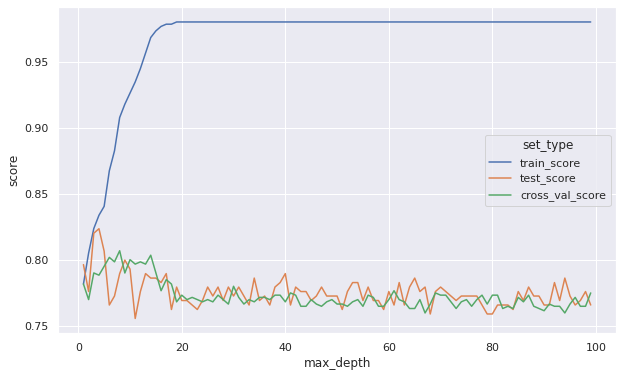

In [39]:
sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

# валидация моделей cross-validation

https://scikit-learn.org/stable/modules/cross_validation.html \
<font size="4">
При k-fold кросс-валидации обучающая выборка разбивается на (k-1) подвыборок и следующий алгоритм выполняется k раз:

- Модель обучается с использованием (k-1) подвыборок в качестве тренировочных данных;
- Полученная модель проверяется на оставшейся одной подвыборке (которая служит тестовым набором для вычисления точности). </font> 

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [34]:
#cv - число folds
cross_val_score(clf, X_test, y_test, cv=5).mean()

0.7966101694915254